# CVAI Project - ZAUBI

In [1]:
import time
import os
import copy
import tqdm

import numpy as np
import PIL as PIL
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
import random
import math
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils import data
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.io import read_image

from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from skimage import io, color

#from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image

In [12]:
DATA_DIR = 'data/mtg-image-data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

CATEGORIES = ['train','val','test']
BATCH_SIZE = 32
NUM_WORKERS = 4

# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 5

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Preprocessing

### Data Collection

In [3]:
# # load the dataset from huggingface
# from datasets import load_dataset
# dataset = load_dataset("Neramas1221/mtg-image-data", split='train')
# dataset

In [4]:
# #remove image at index 20067
# # Identify the corrupted index
# corrupted_index = 20067
# print(f"Original dataset size: {len(dataset)}")
# # Select all rows except the corrupted one
# dataset = dataset.select([i for i in range(len(dataset)) if i != corrupted_index])

# # Verify the removal

# print(f"Cleaned dataset size: {len(dataset)}")

### Feature Engineering

#### Label extraction

In [5]:
from PIL import Image, UnidentifiedImageError

labels = ['colorless', 'blue', 'black', 'white', 'green', 'red']

# Function to extract labels from the text
def replace_label(label):
    label = label.replace('C', 'colorless')
    label = label.replace('U', 'blue')
    label = label.replace('B', 'black')
    label = label.replace('W', 'white')
    label = label.replace('G', 'green')
    label = label.replace('R', 'red')
    return label

def extract_label(text):
    labels = re.findall(r", (U|B|W|G|R|C),", text)
    label = None if len(labels) == 0 else replace_label(labels[0])
    return label

# Function to verify image data
def verify_image(image):
    try:
        if isinstance(image, Image.Image):
            image.verify()  # Verify the integrity of the image
        else:
            return False
        return True
    except (UnidentifiedImageError, ValueError, IOError):
        return False

# Function to add mana color and verify image
def add_mana_color_and_verify_image(example):
    example['mana_color'] = extract_label(example['text'])
    example['image_valid'] = verify_image(example['image'])
    return example


In [6]:

# # Apply the function to the dataset
# dataset = dataset.map(add_mana_color_and_verify_image)

# # Filter out rows with invalid image data
# valid_image_dataset = dataset.filter(lambda x: x['image_valid'])

# # Print the number of valid and invalid images
# invalid_image_count = len(dataset) - len(valid_image_dataset)
# print(f"Number of invalid images: {invalid_image_count}")
# print(f"Number of valid images: {len(valid_image_dataset)}")

# # Check for missing labels
# def check_missing_label(example):
#     return example['mana_color'] is None or example['mana_color'] == ''

# # Filter out rows with missing mana_color
# missing_label_dataset = valid_image_dataset.filter(check_missing_label)

# # Print the number of rows with missing labels
# print(f"Number of rows with missing mana_color: {len(missing_label_dataset)}")

# # Optionally, filter out rows with missing labels
# valid_image_and_label_dataset = valid_image_dataset.filter(lambda x: x['mana_color'] is not None and x['mana_color'] != '')

# # Print the number of valid rows with both valid images and labels
# print(f"Number of valid rows with valid images and labels: {len(valid_image_and_label_dataset)}")


In [7]:
# # save the dataset to disk
# dataset = valid_image_and_label_dataset.remove_columns(['image_valid'])
# dataset.save_to_disk("data/mtg-image-data")

In [8]:
#load the dataset from disk
from datasets import load_from_disk
dataset = load_from_disk("data/mtg-image-data")
dataset

Dataset({
    features: ['image', 'Unnamed: 0', 'text', 'mana_color'],
    num_rows: 23848
})

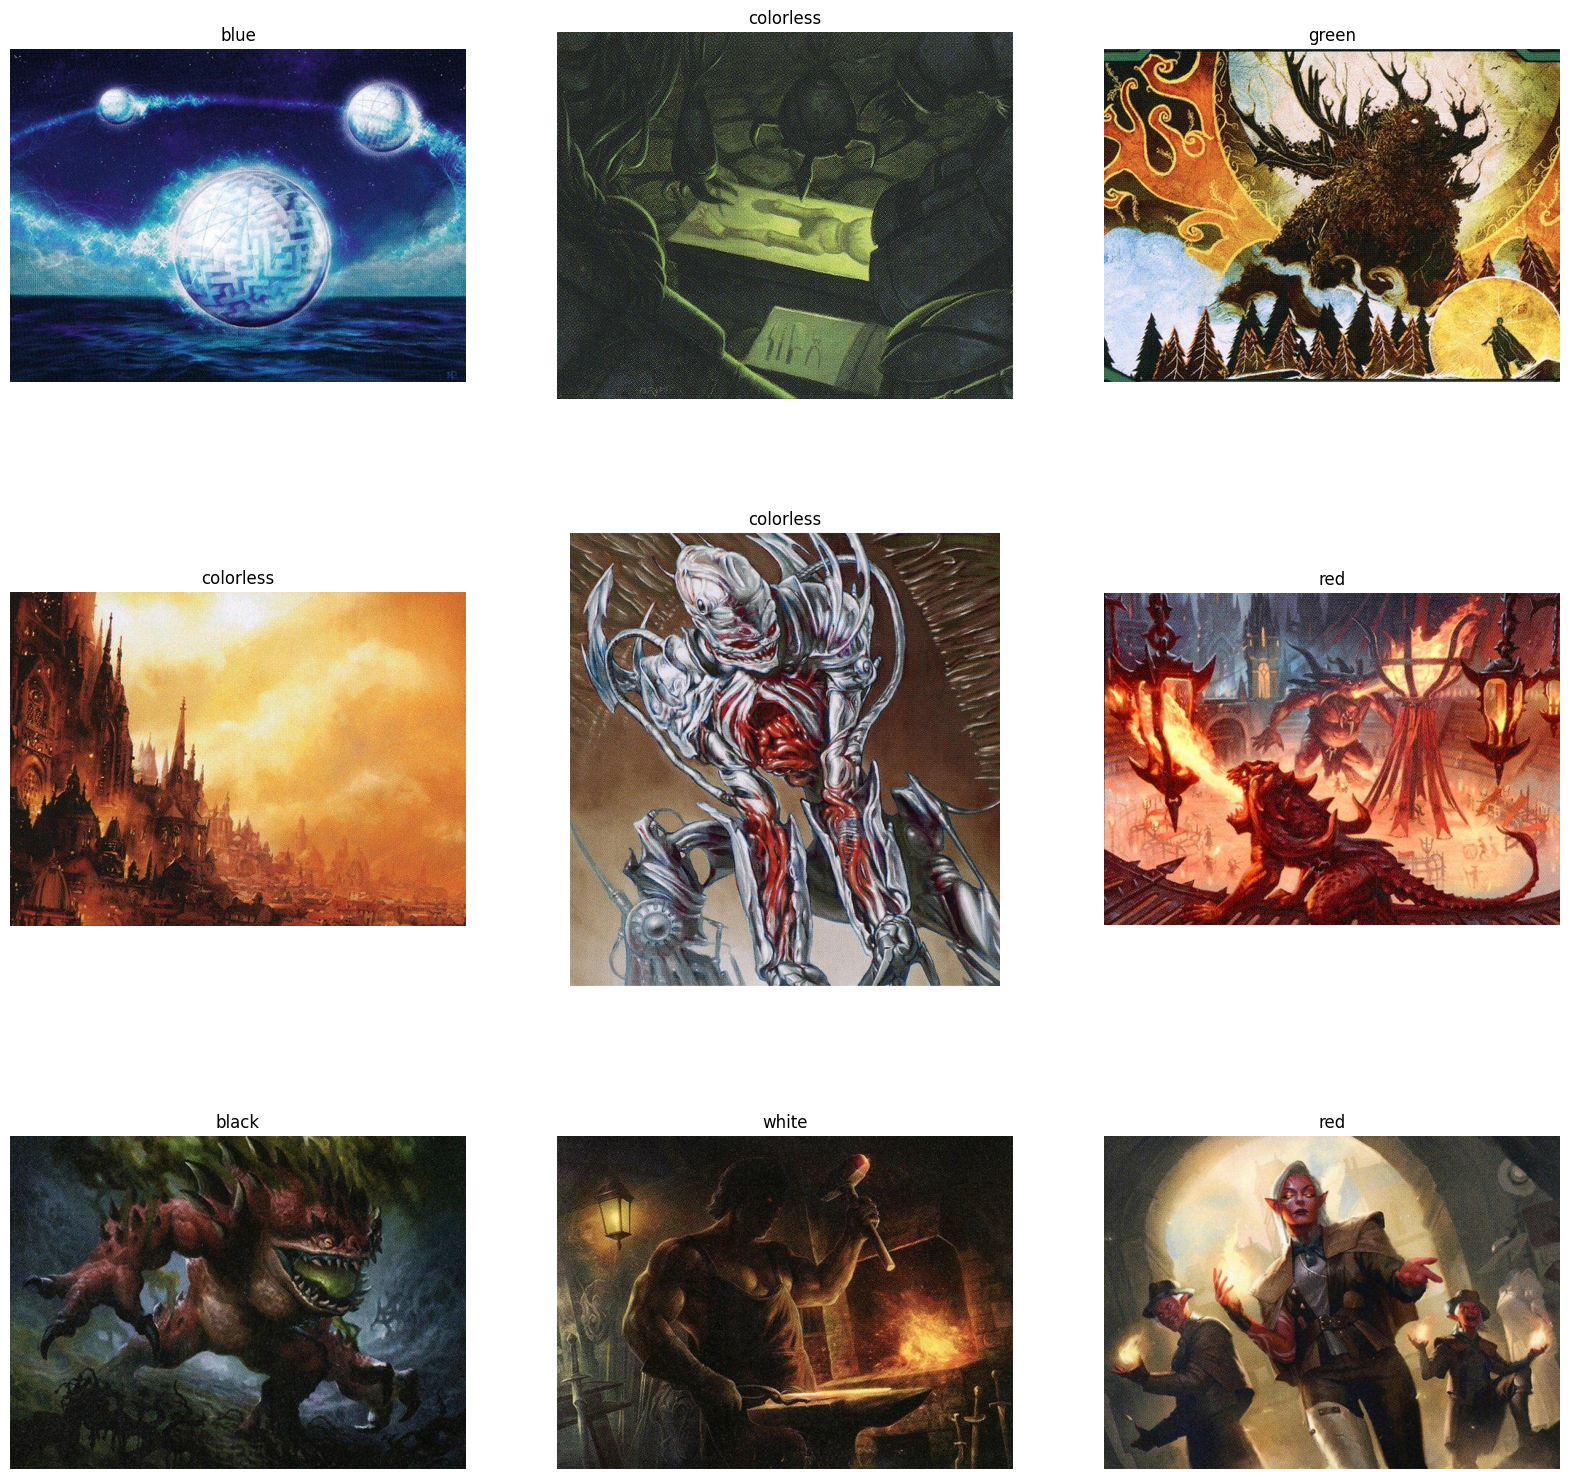

In [9]:
# Define a function to visualize n random images with mana color labels, 3 per row
def visualize_images(dataset, n=9):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        plt.subplot(n // 3, 3, i + 1)
        random_index = random.randint(0, len(dataset))
        image = dataset[random_index]['image']
        label = dataset[random_index]['mana_color']
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Visualize some random images
visualize_images(dataset)



In [10]:
type(dataset)

datasets.arrow_dataset.Dataset

In [11]:
# Compute the labels distribution

label_counts = {label: 0 for label in labels}
for example in dataset:
    label = example['mana_color']
    label_counts[label] += 1
label_counts

{'colorless': 5381,
 'blue': 3632,
 'black': 3725,
 'white': 3749,
 'green': 3716,
 'red': 3645}

In [14]:
# plot the distribution of labels
from plotly import express as px
fig = px.bar(x=labels, y=[label_counts[label] for label in labels], title='Mana Color Distribution', color=labels)
fig.update_layout(xaxis_title='Mana Color', yaxis_title='Count', showlegend=False)
fig.show()

## Model Building

### Load the pre-trained model

In [15]:
import ssl
from torchvision.models import resnet50, ResNet50_Weights

ssl._create_default_https_context = ssl._create_unverified_context

# Initialize the Weight Transform
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [16]:
# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

In [17]:
# Modify the last layer to fit the number of classes
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, len(labels))
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [1]:
# Custom Dataset class for handling the specific image format
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image_data = item['image'].convert("RGB")  # Convert to RGB if necessary
        if self.transform:
            image = self.transform(image_data)
        label = labels.index(item['mana_color'])
        label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return image, label

# Split the dataset into train, val, and test sets (e.g., 80% train, 10% val, 10% test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Apply transformations to each split
train_dataset = CustomImageDataset(train_dataset, transform=transform)
val_dataset = CustomImageDataset(val_dataset, transform=transform)
test_dataset = CustomImageDataset(test_dataset, transform=transform)

print(f"Train dataset size: {len(train_dataset)}", f"Val dataset size: {len(val_dataset)}", f"Test dataset size: {len(test_dataset)}", sep='\n')

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

NameError: name 'Dataset' is not defined

In [34]:
from tqdm import tqdm

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader with tqdm
        for inputs, labels in tqdm(train_loader, desc='Training'):
            # Move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader with tqdm
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                # Move the inputs and labels to the device
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.double() / len(val_loader.dataset)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))


In [35]:
# Set the device
model.to(DEVICE)

# Fine-tune the last layer for a few epochs
optimizer = torch.optim.SGD(model.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)

# # Unfreeze all the layers and fine-tune the entire network for a few more epochs
# for param in model.parameters():
#     param.requires_grad = True
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/5


Training:   1%|          | 4/597 [00:10<25:52,  2.62s/it]


KeyboardInterrupt: 

In [ ]:
# make 10 predictions and visualize the images, label, and predicted labels and probabilities 
def visualize_predictions(model, test_loader, n_images=10):
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                plt.figure()
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0))
                plt.title(f'Label: {labels[j]}, Prediction: {preds[j]}')
                plt.show()

            if i >= n_images - 1:
                break

# Visualize predictions
visualize_predictions(model, test_loader, n_images=10)


In [ ]:
# Evaluate the model on the test set
def evaluate(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    # Initialize the running loss and corrects
    running_loss = 0.0
    running_corrects = 0

    # Initialize the predictions and labels list
    all_preds = []
    all_labels = []

    # Iterate over the batches of the test loader
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            # Move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Update the running loss and corrects
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Append the predictions and labels to the lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Calculate the test loss and accuracy
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    
    return test_loss, test_acc, all_preds, all_labels

# Evaluate the model
test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")
    